# Dog Breed Classifier

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app. At the end of this project, your code will accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most resembling.

## Import Dog Dataset

Lets load the data

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob
import os
import warnings
warnings.filterwarnings("ignore")

# Construct the paths
train_path = os.path.join('dog_dataset', 'train')
valid_path = os.path.join('dog_dataset', 'valid')
test_path  = os.path.join('dog_dataset', 'test')

train_subdir = sorted(glob('/'.join([train_path , '*/'])))

# check the types of dogs available in the dataset
dog_names = [item[20:-1] for item in train_subdir ]
print('Total no. of dog categories :{}'.format(len(dog_names)))

Using TensorFlow backend.


Total no. of dog categories :133


In [2]:
# Define function to load the data

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    
    return dog_files ,dog_targets

# Loading the datasets
train_data , train_target = load_dataset(train_path)
valid_data , valid_target = load_dataset(valid_path)
test_data , test_target   = load_dataset(test_path)
    
print('No. of dog images training sets : {}'.format(len(train_data)))
print('No. of dog images test sets : {}'.format(len(test_data)))
print('No. of dog images validation sets : {}'.format(len(valid_data)))
print('Total dog images : {}'.format(len(np.hstack([train_data , valid_data, test_data]))))


No. of dog images training sets : 6680
No. of dog images test sets : 836
No. of dog images validation sets : 835
Total dog images : 8351


### Import Human dataset

In [3]:
import random

random.seed(42)
human_faces_path = os.path.join('human_dataset', 'lfw')

human_subdir = sorted(glob('/'.join([human_faces_path , '*/*'])))

human_files = np.array(human_subdir)

random.shuffle(human_files)

print('Total no. of Human Files : {}'.format(len(human_files)))

Total no. of Human Files : 13233


### Detecting Human Faces

We can detect Human Faces using  OpenCV's one of many pretrained Haar Classifiers

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline                               

face_cascade = cv2.CascadeClassifier('haar_classifier/haarcascade_frontalface_default.xml')

image = cv2.imread(human_files[129])

gray_scaled_image = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray_scaled_image)

print('Number of faces detected :{}'.format(len(faces)))

Number of faces detected :1


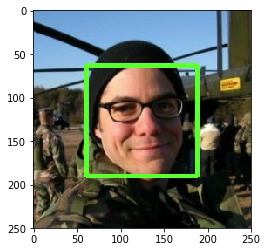

In [5]:
# Get bounding box of each faces and display the image
for (x,y,w,h) in faces:
    cv2.rectangle(image,(x,y), (x+w , y+h) ,(50,400,92),3 )

color_image = cv2.cvtColor(image ,cv2.COLOR_BGR2RGB)

plt.imshow(color_image)
plt.show()

In [6]:
def face_detector(image_path):
    img = cv2.imread(image_path)
    gray_scaled_image = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_scaled_image)
    return (len(faces) > 0) 

In [7]:
# Test the performance of Human Face Detector
human_files_subset = human_files[:100]
dog_files_subset = train_data[:100]

human_detections = np.sum([face_detector(image) for image in human_files_subset])
dog_detections = np.sum([face_detector(image) for image in dog_files_subset])

print('Face Detections for Human dataset :{}%'.format(human_detections))
print('Face Detections for Dog dataset :{}%'.format(dog_detections))

Face Detections for Human dataset :100%
Face Detections for Dog dataset :54%


## Detect Dogs

#### Using ResNet-50

In [8]:
from keras.applications.resnet50 import ResNet50
from keras import backend,models,utils,layers

# Using Weights from the Imagenet database
model_resnet50 = ResNet50( weights = 'imagenet')

W0919 21:02:11.701751  3316 deprecation_wrapper.py:119] From C:\Users\i323570\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0919 21:02:11.729675  3316 deprecation_wrapper.py:119] From C:\Users\i323570\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0919 21:02:11.737654  3316 deprecation_wrapper.py:119] From C:\Users\i323570\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0919 21:02:11.819435  3316 deprecation_wrapper.py:119] From C:\Users\i323570\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is depreca

In [9]:
# prepare images to be loaded into ResNet50
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    
    img = image.load_img(path = img_path ,target_size=(224 ,224))
    #convert to 3D tensor
    x = image.img_to_array(img)
    return np.expand_dims(x, axis = 0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(path) for path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


In [10]:
from keras.applications.resnet50 import preprocess_input , decode_predictions

def ResNet50_predict_labels(img_path):
    image = preprocess_input(path_to_tensor(img_path))
    return np.argmax(model_resnet50.predict(image))

In [11]:
# Dog Detector
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [12]:
human_as_dog_percentage = sum([dog_detector(img_path) for img_path in human_files_subset ])
dogs_as_dog_percentage = sum([dog_detector(img_path) for img_path in dog_files_subset ])

print('Images with human incorrectly detected as dogs: {}'.format(human_as_dog_percentage))
print('Images with Dogs correctly detected as dogs: {}'.format(dogs_as_dog_percentage))


Images with human incorrectly detected as dogs: 0
Images with Dogs correctly detected as dogs: 100


#### Using CNN built from Scratch

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True  
# We have to normalize the pixel values in the image
training_tensors = paths_to_tensor(train_data).astype('float32')/255
validation_tensors = paths_to_tensor(valid_data).astype('float32')/255
testing_tensors = paths_to_tensor(test_data).astype('float32')/255

100%|██████████| 836/836 [00:11<00:00, 74.05it/s] 


In [14]:
training_tensors.shape

(6680, 224, 224, 3)

In [20]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation ,Dropout
from keras import regularizers
from keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization ,MaxPooling2D ,Flatten
from sklearn.metrics import f1_score
def build_model( input_shape, categories_to_predict ):
    
    model = Sequential()
    
#     X_input = Input(input_shape)
    
    model.add(ZeroPadding2D(3, input_shape = input_shape))
    model.add(Conv2D(10 ,(7,7) ,kernel_regularizer= regularizers.l2(0.01))) 
    model.add(BatchNormalization(axis = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size = (6,6)) )
    model.add(Conv2D(20 ,(7,7) ))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size = (6,6)) )
    
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(categories_to_predict))
    model.add(Activation('softmax'))
    
    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 
    
    return model

In [22]:
len(train_target)

6680

In [23]:
IMAGE_SHAPE = 224, 224, 3
model = build_model(IMAGE_SHAPE , len(dog_names))

W0919 21:08:30.922785  3316 deprecation.py:506] From C:\Users\i323570\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0919 21:08:31.035513  3316 deprecation_wrapper.py:119] From C:\Users\i323570\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [25]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
checkpointer = ModelCheckpoint(filepath='best_model_weights.hdf5',monitor='val_acc' ,
                               verbose=1, save_best_only=True)

In [27]:
import time
# Start the training
start_time = time.time()
start_time = time.time()

model.fit(x=training_tensors, y=train_target, batch_size=128, epochs=4, validation_data=(validation_tensors, valid_target),
         callbacks= [checkpointer,EarlyStopping(monitor='val_loss', patience=15, verbose=1)])

end_time = time.time()
execution_time = (end_time - start_time)

print('Elapsed time for training:{:,.2f}'.format(execution_time))

W0919 21:12:14.638793  3316 deprecation.py:323] From C:\Users\i323570\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6680 samples, validate on 835 samples
Epoch 1/4
6680/6680 [==============================] - ETA: 7:05 - loss: 7.1510 - acc: 0.0000e+0 - ETA: 5:49 - loss: 6.4301 - acc: 0.0000e+0 - ETA: 5:24 - loss: 6.0465 - acc: 0.0026    - ETA: 5:12 - loss: 5.8175 - acc: 0.003 - ETA: 5:04 - loss: 5.6551 - acc: 0.007 - ETA: 4:52 - loss: 5.5506 - acc: 0.006 - ETA: 4:46 - loss: 5.4669 - acc: 0.005 - ETA: 4:37 - loss: 5.4034 - acc: 0.004 - ETA: 4:28 - loss: 5.3537 - acc: 0.004 - ETA: 4:22 - loss: 5.3105 - acc: 0.005 - ETA: 4:15 - loss: 5.2777 - acc: 0.006 - ETA: 4:10 - loss: 5.2491 - acc: 0.005 - ETA: 4:05 - loss: 5.2251 - acc: 0.006 - ETA: 3:59 - loss: 5.2039 - acc: 0.005 - ETA: 3:55 - loss: 5.1862 - acc: 0.005 - ETA: 3:49 - loss: 5.1705 - acc: 0.005 - ETA: 3:42 - loss: 5.1567 - acc: 0.005 - ETA: 3:36 - loss: 5.1437 - acc: 0.005 - ETA: 3:31 - loss: 5.1326 - acc: 0.005 - ETA: 3:24 - loss: 5.1229 - acc: 0.005 - ETA: 3:19 - loss: 5.1142 - acc: 0.005 - ETA: 3:12 - loss: 5.1060 - acc: 0.005 - ETA: 3

6680/6680 [==============================] - ETA: 5:07 - loss: 4.5973 - acc: 0.039 - ETA: 5:12 - loss: 4.6278 - acc: 0.031 - ETA: 5:13 - loss: 4.6327 - acc: 0.028 - ETA: 4:58 - loss: 4.6469 - acc: 0.025 - ETA: 4:50 - loss: 4.6620 - acc: 0.029 - ETA: 4:43 - loss: 4.6760 - acc: 0.027 - ETA: 4:34 - loss: 4.6884 - acc: 0.026 - ETA: 4:27 - loss: 4.6938 - acc: 0.024 - ETA: 4:20 - loss: 4.6936 - acc: 0.022 - ETA: 4:14 - loss: 4.7044 - acc: 0.021 - ETA: 4:08 - loss: 4.7025 - acc: 0.019 - ETA: 4:01 - loss: 4.6916 - acc: 0.023 - ETA: 3:54 - loss: 4.6912 - acc: 0.024 - ETA: 3:47 - loss: 4.6926 - acc: 0.024 - ETA: 3:41 - loss: 4.6915 - acc: 0.025 - ETA: 3:36 - loss: 4.6876 - acc: 0.024 - ETA: 3:29 - loss: 4.6860 - acc: 0.024 - ETA: 3:22 - loss: 4.6902 - acc: 0.026 - ETA: 3:16 - loss: 4.6841 - acc: 0.025 - ETA: 3:10 - loss: 4.6854 - acc: 0.024 - ETA: 3:04 - loss: 4.6846 - acc: 0.025 - ETA: 2:58 - loss: 4.6784 - acc: 0.025 - ETA: 2:51 - loss: 4.6763 - acc: 0.025 - ETA: 2:46 - loss: 4.6764 - acc: 0.0

In [ ]:
# Load model with Best validation Loss
model.load_weights('best_model_weights.hdf5')

In [ ]:
model.lo